#패키지 설치

In [1]:
!pip install keras==2.12.0
!pip install shap


# 한국어 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

^C
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truety

#Import

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
import shap


#전처리

In [6]:
file_path = 'train_OutlierRemoval.csv'
data = pd.read_csv(file_path)

# Drop unnecessary columns and split into X and y
X = data.drop(['label', 'Unnamed: 0', 'ID','콜레스테롤'], axis=1)
y = data['label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.head()

,나이,키(cm),몸무게(kg),시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
1612,55,145,45,0.90,0,95,46.0,88,0.8,93.000000,207.0,13.5,1,1.14
978,55,160,55,0.50,0,94,42.0,107,0.7,100.876263,81.0,14.6,1,1.15
3050,40,170,60,1.35,0,102,28.0,230,1.0,40.000000,157.0,16.0,1,1.60
4960,55,165,55,0.90,1,101,54.0,47,0.9,54.000000,124.0,12.8,1,1.11
2548,60,170,65,1.00,0,98,40.0,173,0.9,25.000000,55.0,15.8,1,0.88


#스케일링

In [7]:
# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#DNN

In [8]:
def create_model(optimizer='SGD', init='normal'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model, verbose=0)


param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20],
    'optimizer': ['SGD', 'Adam'],
    'init': ['uniform', 'normal']
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


<ipython-input-8-9007493dd130>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#최적의 파라미터

In [9]:
print(f'Best Accuracy: {grid_result.best_score_:.4f}')
print(f'Best Parameters: {grid_result.best_params_}')


Best Accuracy: 0.7355
Best Parameters: {'batch_size': 10, 'epochs': 10, 'init': 'normal', 'optimizer': 'Adam'}


#성능지표

66/66 [==============================] - 0s 1ms/step

Test Set Metrics:
Accuracy: 0.7090
F1 Score: 0.6056
Precision: 0.5967
Recall: 0.6147
66/66 [==============================] - 0s 1ms/step


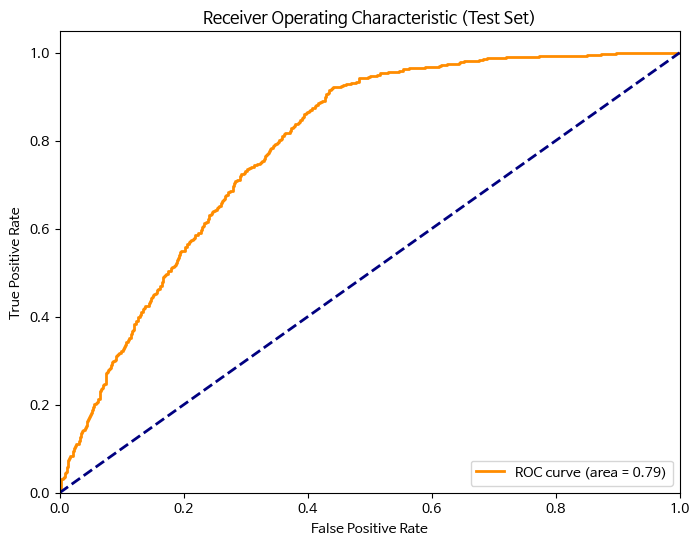

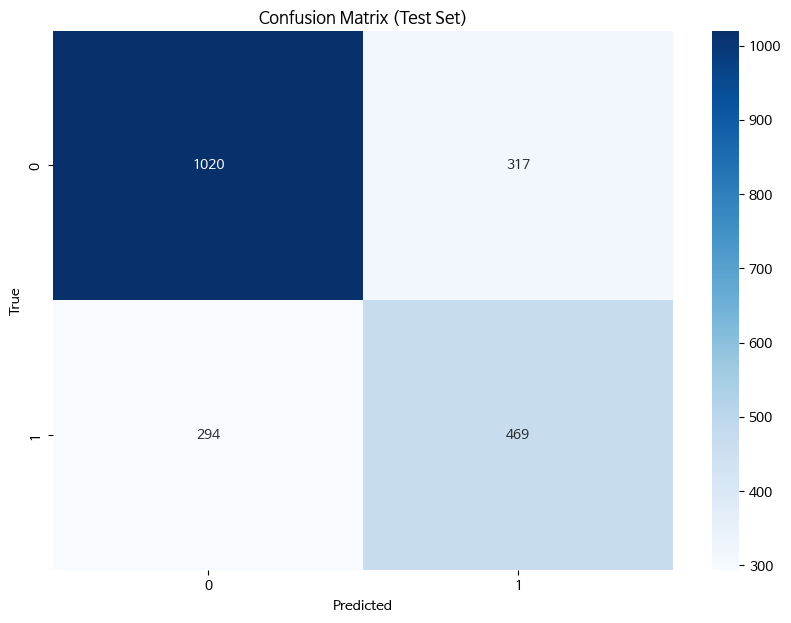

In [10]:
best_model = grid_result.best_estimator_
y_pred_test = (best_model.predict(X_test_scaled) > 0.5).astype(int)

# Calculate metrics for test set
acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

# Print metrics for test set
print(f'\nTest Set Metrics:')
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Score: {f1_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')

# Compute ROC curve and AUC for test set
fpr_test, tpr_test, _ = roc_curve(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc='lower right')
plt.show()

# Plot the confusion matrix for test set
plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

#교차 검증

In [14]:
# K-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(best_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print(f'Cross-Validation accuracy scores: {cv_results}')
print(f'Mean accuracy: {cv_results.mean():.4f}')

31/31 [==============================] - 0s 1ms/step
Cross-Validation accuracy scores: [0.73061224 0.73061224 0.71734694 0.72959184 0.72857143]
Mean accuracy: 0.7273


#SHAP

In [11]:

# 원래 피처 이름을 저장
feature_names = X_train.columns

PermutationExplainer explainer: 4901it [07:48, 10.34it/s]


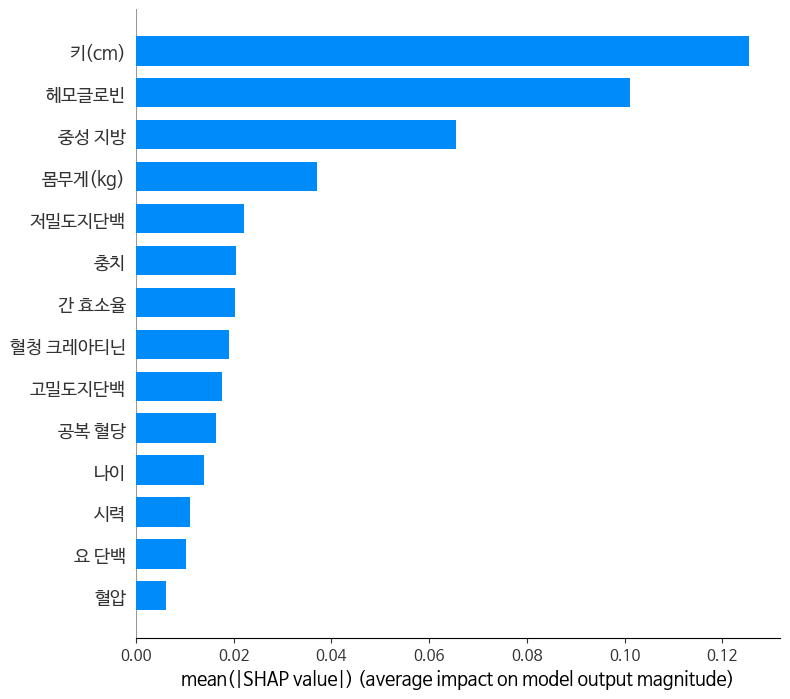

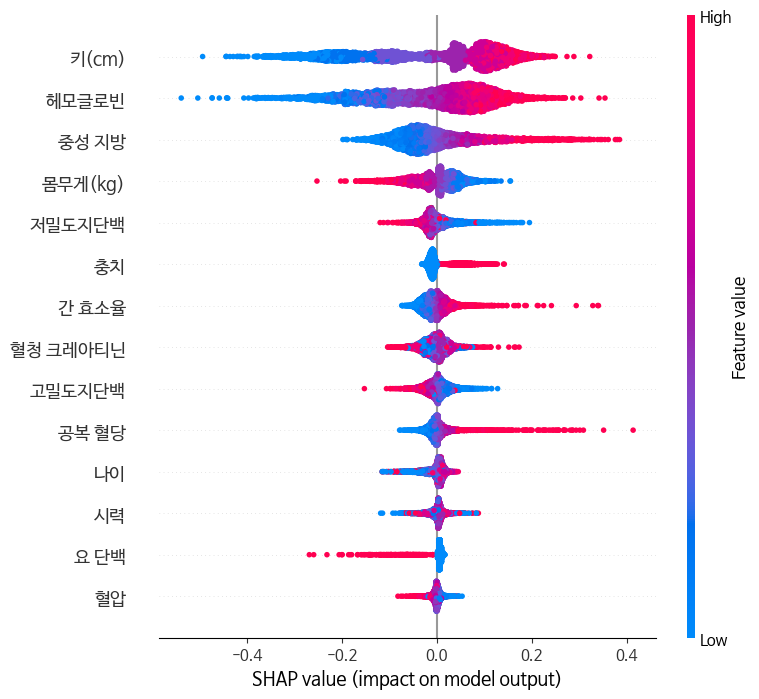

In [12]:
# SHAP 분석 (PCA된 데이터 사용)
explainer = shap.Explainer(best_model.model, X_train_scaled)
shap_values = explainer(X_train_scaled)
# Global feature importance
shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names ,plot_type="bar")

# Local explanation summary
shap.summary_plot(shap_values, features=X_train_scaled,feature_names=feature_names )